In [ ]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading checkpoint...
Resuming training from epoch 10


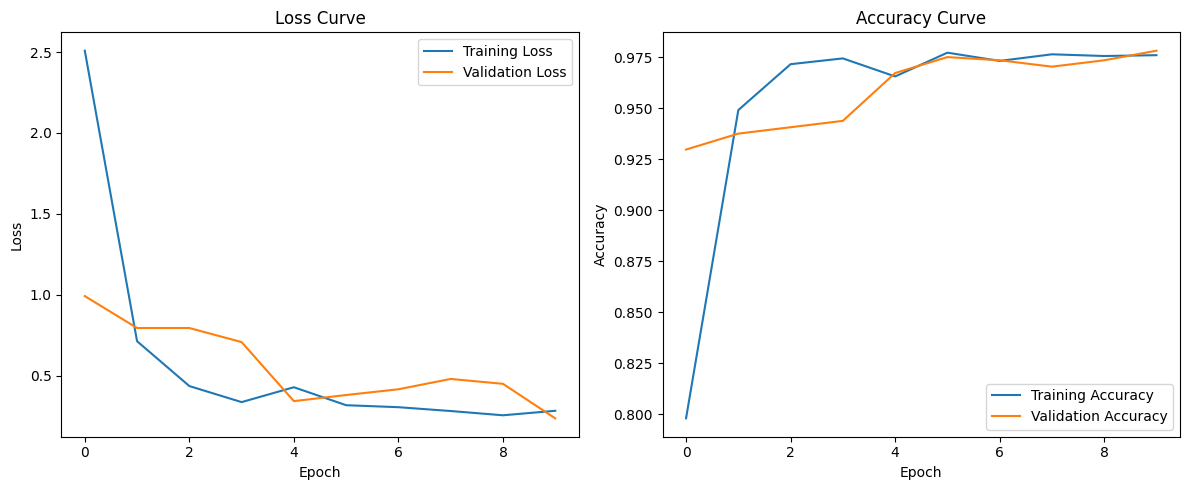

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. MOUNT GOOGLE DRIVE
# ----------------------------------------------------------------------

drive.mount('/content/drive')

# ----------------------------------------------------------------------
# 2. DATASET CLASS (ClockDataset)
# ----------------------------------------------------------------------

class ClockDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in range(6):  # Assuming 6 classes (0 to 5)
            class_dir = os.path.join(self.root_dir, str(label))
            if not os.path.exists(class_dir):  # Handle missing directories
                print(f"Warning: Directory {class_dir} does not exist. Skipping.")
                continue

            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.image_paths.append(image_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')  # Ensure RGB format
        except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
            print(f"Error loading image: {image_path} - {e}")
            return None  # Skip the sample

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)  # Return as LongTensor for classification

# ----------------------------------------------------------------------
# 3. DATA TRANSFORMATIONS
# ----------------------------------------------------------------------

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ----------------------------------------------------------------------
# 4. LOAD DATASET AND CREATE DATALOADERS
# ----------------------------------------------------------------------

root_dir = "/content/drive/My Drive/clock_shulman"  # **REPLACE WITH YOUR ACTUAL GOOGLE DRIVE PATH**
dataset = ClockDataset(root_dir=root_dir, transform=data_transforms)

# Remove None values from dataset
dataset.image_paths = [path for path in dataset.image_paths if path is not None]
dataset.labels = [label for label, path in zip(dataset.labels, dataset.image_paths) if path is not None]

# Split data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

def collate_fn(batch):
    """
    Custom collate function to filter out None values from the batch.
    """
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.default_collate(batch)  # Use default collate function for valid data

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# ----------------------------------------------------------------------
# 5. LOAD PRE-TRAINED RESNET AND MODIFY CLASSIFIER
# ----------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your pre-trained ResNet model
checkpoint_path = "/content/drive/My Drive/clock_checkpoints/last_checkpoint.pth"  # Path to your saved checkpoint
checkpoint = torch.load(checkpoint_path)

# Initialize the ResNet model
resnet = models.resnet50(pretrained=False)  # Set pretrained=False since you're loading your own weights
resnet.fc = nn.Linear(resnet.fc.in_features, 6)  # Match the final layer to your dataset (6 classes)

# Load the saved weights
resnet.load_state_dict(checkpoint['model_state_dict'])
resnet.to(device)  # Move the model to the appropriate device (GPU or CPU)

# Remove the final classification layer for the backbone
backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final layer (fc)
backbone.to(device)

# ----------------------------------------------------------------------
# 6. DEFINE API-NET COMPONENTS
# ----------------------------------------------------------------------

class APIComponent(nn.Module):
    def __init__(self, feature_dim):
        super(APIComponent, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(feature_dim, feature_dim)
        )

    def forward(self, x1, x2):
        xm = torch.cat((x1, x2), dim=1)
        xm = self.mlp(xm)
        g1 = torch.sigmoid(xm * x1)
        g2 = torch.sigmoid(xm * x2)
        x1_self = x1 + x1 * g1
        x2_self = x2 + x2 * g2
        x1_other = x1 + x1 * g2
        x2_other = x2 + x2 * g1
        return x1_self, x1_other, x2_self, x2_other

class Classifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

class APINet(nn.Module):
    def __init__(self, backbone, api_component, classifier):
        super(APINet, self).__init__()
        self.backbone = backbone
        self.api_component = api_component
        self.classifier = classifier

    def forward(self, x1, x2):
        # Pass inputs through the backbone
        x1 = self.backbone(x1)  # Output shape: [batch_size, num_features, 1, 1]
        x2 = self.backbone(x2)  # Output shape: [batch_size, num_features, 1, 1]

        # Squeeze the last two dimensions
        x1 = x1.squeeze(-1).squeeze(-1)  # Shape: [batch_size, num_features]
        x2 = x2.squeeze(-1).squeeze(-1)  # Shape: [batch_size, num_features]

        # Pass through the API component
        x1_self, x1_other, x2_self, x2_other = self.api_component(x1, x2)

        # Pass through the classifier
        p1_self = self.classifier(x1_self)
        p1_other = self.classifier(x1_other)
        p2_self = self.classifier(x2_self)
        p2_other = self.classifier(x2_other)

        return p1_self, p1_other, p2_self, p2_other

# Initialize API-Net
api_component = APIComponent(feature_dim=2048)  # ResNet-50 feature dimension is 2048
classifier = Classifier(feature_dim=2048, num_classes=6)  # 6 classes for Shulman scores
model = APINet(backbone, api_component, classifier)
model.to(device)

# ----------------------------------------------------------------------
# 7. DEFINE LOSS FUNCTION AND OPTIMIZER
# ----------------------------------------------------------------------

import torch.nn.functional as F

def loss_function(p1_self, p1_other, p2_self, p2_other, y1, y2, lambda_rk=0.1, epsilon=0.1):
    ce_loss = nn.CrossEntropyLoss()
    loss_ce = ce_loss(p1_self, y1) + ce_loss(p1_other, y1) + ce_loss(p2_self, y2) + ce_loss(p2_other, y2)
    loss_rk = torch.max(torch.zeros_like(p1_other), p1_other - p1_self + epsilon).mean() + \
              torch.max(torch.zeros_like(p2_other), p2_other - p2_self + epsilon).mean()
    return loss_ce + lambda_rk * loss_rk

optimizer = optim.Adam(model.parameters(), lr=0.00005)

# ----------------------------------------------------------------------
# 8. CHECKPOINTING AND VISUALIZATION
# ----------------------------------------------------------------------

checkpoint_dir = "/content/drive/My Drive/API-Net-Checkpoints"  # Where to save checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_epoch = 0  # Start from epoch 0, unless resuming from a checkpoint
checkpoint_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")  # Path to save the last checkpoint

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    print(f"Resuming training from epoch {start_epoch}")

# ----------------------------------------------------------------------
# 9. TRAINING LOOP
# ----------------------------------------------------------------------

num_epochs = 10  # or more

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(labels))

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        p1_self, p1_other, p2_self, p2_other = model(images, images)  # Use the same image for pairwise comparison
        loss = loss_function(p1_self, p1_other, p2_self, p2_other, labels, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_accuracy(p1_self, labels)  # Use p1_self for accuracy calculation

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            p1_self, p1_other, p2_self, p2_other = model(images, images)
            loss = loss_function(p1_self, p1_other, p2_self, p2_other, labels, labels)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(p1_self, labels)

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

# ----------------------------------------------------------------------
# 10. PLOT LOSS AND ACCURACY CURVES
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

import requests
from io import BytesIO
def predict_image_from_url(image_url):
    try:
        # Download the image from the URL
        response = requests.get(image_url, stream=True)
        response.raise_for_status()

        # Open and preprocess the image
        image = Image.open(BytesIO(response.content)).convert('RGB')
        image = data_transforms(image).unsqueeze(0).to(device)  # Add batch dimension: [1, 3, 224, 224]

        # Pass the same image twice to the model
        model.eval()
        with torch.no_grad():
            p1_self, p1_other, p2_self, p2_other = model(image, image)  # Use the same image for both inputs
            _, predicted = torch.max(p1_self, 1)  # Use p1_self for prediction

        return predicted.item()

    except Exception as e:
        print(f"Error processing image from URL: {e}")
        return None

image_url = "https://i.ibb.co/Y49X1Qn3/22953-1.png"
predicted_class = predict_image_from_url(image_url)

if predicted_class is not None:
    print(f'The predicted class for the clock image is: {predicted_class}')
else:
    print("Could not predict the class for the image.")

Error processing image from URL: HTTPSConnectionPool(host='i.ibb.co', port=443): Max retries exceeded with url: /Y49X1Qn3/22953-1.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7cfe46c6fc90>, 'Connection to i.ibb.co timed out. (connect timeout=None)'))
Could not predict the class for the image.


In [ ]:
def calculate_accuracy(model, data_loader, device):
    """
    Calculate the accuracy of the model on a given dataset.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset (validation or test set).
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        accuracy: The accuracy of the model on the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            p1_self, p1_other, p2_self, p2_other = model(images, images)
            _, predicted = torch.max(p1_self, 1)  # Use p1_self for prediction

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Load the validation or test dataset
val_dataset = ClockDataset(root_dir=root_dir, transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Calculate accuracy
accuracy = calculate_accuracy(model, val_loader, device)
print(f'Accuracy on the validation set: {accuracy:.2f}%')

Accuracy on the validation set: 98.27%
